In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import scipy
import statsmodels.api as sm
import inspect
import time
import re
import pprint
import datetime
import json


# Current Outputs:

### Gene Length | startScore | midScore | endScore | GC Ratio | Entropy | oneHotStart | oneHotMid | oneHotStop | Match


In [12]:


def parse_batch_log_to_json(log_text, title, json_path="batch_logs.json"):
    """
    Parses batch log text and appends it to a JSON file under the given title.
    Each entry includes a date/time created field. Duplicate titles are not allowed.
    Args:
        log_text: The raw log text to parse.
        title: The unique title for this log (used as a key in the JSON file).
        json_path: Path to the JSON file to write to (default: batch_logs.json).
    Returns:
        True if added, False if duplicate title.
    """
    # Parse the log text into a list of dictionaries
    pattern = re.compile(
        r'Batch\s+([\d\w]+):\s+ERR=\s*([\d\.]+)\s+WER=\s*([\d\.]+)\s+FPR=\s*([\d\.]+)\s+FNR=\s*([\d\.]+)\s+CTF=\s*([\d\.\-]+)\s+([\d\.]+)s'
    )
    result = []
    for line in log_text.strip().split('\n'):
        match = pattern.match(line)
        if match:
            batch = match.group(1)
            if batch.endswith('k'):
                batch_num = int(float(batch[:-1]) * 1000)
            else:
                batch_num = int(batch)
            entry = {
                'Batch': batch_num,
                'ERR': float(match.group(2)),
                'WER': float(match.group(3)),
                'FPR': float(match.group(4)),
                'FNR': float(match.group(5)),
                'CTF': float(match.group(6)),
                'Training Time': float(match.group(7))
            }
            result.append(entry)
    # Prepare the new log entry
    log_entry = {
        'title': title,
        'created': datetime.datetime.now().isoformat(),
        'batches': result
    }  # Load or create the JSON file
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            try:
                logs = json.load(f)
            except json.JSONDecodeError:
                logs = []
    else:
        logs = []
    # Check for duplicate title
    if any(log.get('title') == title for log in logs):
        print(f"Duplicate title '{title}' found. Not adding.")
        return False
    # Append and save
    logs.append(log_entry)
    with open(json_path, 'w') as f:
        json.dump(logs, f, indent=2)
    print(f"Log '{title}' added to {json_path}.")
    return True





In [20]:


def parse_batch_log(log_text):
    """
    Parses batch log text into a list of dictionaries.
    Each dictionary contains metrics for a batch.
    Also returns a string with each parsed line followed by a newline.
    """
    pattern = re.compile(
        r'Batch\s+([\d\w]+):\s+ERR=\s*([\d\.]+)\s+WER=\s*([\d\.]+)\s+FPR=\s*([\d\.]+)\s+FNR=\s*([\d\.]+)\s+CTF=\s*([\d\.\-]+)\s+([\d\.]+)s'
    )
    result = []
    parsed_lines = ""
    for line in log_text.strip().split('\n'):
        match = pattern.match(line)
        if match:
            batch = match.group(1)
            # Convert batch like '10k' to integer
            if batch.endswith('k'):
                batch_num = int(float(batch[:-1]) * 1000)
            else:
                batch_num = int(batch)
            entry = {
                'Batch': batch_num,
                'ERR': float(match.group(2)),
                'WER': float(match.group(3)),
                'FPR': float(match.group(4)),
                'FNR': float(match.group(5)),
                'CTF': float(match.group(6)),
                'Training Time': float(match.group(7))
            }
            result.append(entry)
    return result, parsed_lines

# Example usage:
log_text = """
Batch 1:	ERR= 0.354261	WER= 3.178758	FPR= 0.201759	FNR= 0.201751	CTF= 0.747763	78.0s
Batch 4:	ERR= 0.322559	WER= 2.908154	FPR= 0.201418	FNR= 0.201411	CTF= 0.766739	13.8s
Batch 16:	ERR= 0.256792	WER= 2.275173	FPR= 0.198903	FNR= 0.198896	CTF= 0.701138	19.5s
Batch 64:	ERR= 0.148923	WER= 1.335035	FPR= 0.182382	FNR= 0.182367	CTF= 0.582260	36.5s
Batch 256:	ERR= 0.126531	WER= 1.078542	FPR= 0.134590	FNR= 0.134563	CTF= 0.398820	47.1s
Batch 1024:	ERR= 0.094160	WER= 0.787256	FPR= 0.092386	FNR= 0.092352	CTF= 0.421237	63.7s
Batch 4096:	ERR= 0.056718	WER= 0.336434	FPR= 0.049991	FNR= 0.049982	CTF= 0.425454	214s
Batch 10k:	ERR= 0.323696	WER= 0.676305	FPR= 0.044672	FNR= 0.044668	CTF= 0.243043	397s
Batch 20k:	ERR= 0.102648	WER= 0.316091	FPR= 0.035244	FNR= 0.035236	CTF= 0.358049	652s
Batch 30k:	ERR= 0.083083	WER= 0.291425	FPR= 0.029660	FNR= 0.029649	CTF= 0.413862	649s
Batch 40k:	ERR= 0.062296	WER= 0.211162	FPR= 0.028291	FNR= 0.028281	CTF= 0.475366	651s
Batch 50k:	ERR= 0.062421	WER= 0.231720	FPR= 0.027602	FNR= 0.027593	CTF= 0.472773	650s
Batch 60k:	ERR= 0.075634	WER= 0.440798	FPR= 0.026625	FNR= 0.026614	CTF= 0.479406	647s
Batch 70k:	ERR= 0.057610	WER= 0.240517	FPR= 0.025799	FNR= 0.025787	CTF= 0.525959	649s
Batch 80k:	ERR= 0.057710	WER= 0.234564	FPR= 0.025259	FNR= 0.025247	CTF= 0.490700	650s
Batch 90k:	ERR= 0.065424	WER= 0.329272	FPR= 0.024926	FNR= 0.024908	CTF= 0.469173	656s
Batch 100k:	ERR= 0.064317	WER= 0.315302	FPR= 0.024115	FNR= 0.024094	CTF= 0.492339	724s
Batch 110k:	ERR= 0.067606	WER= 0.337798	FPR= 0.023552	FNR= 0.023536	CTF= 0.473716	612s
Batch 120k:	ERR= 0.068520	WER= 0.376349	FPR= 0.022529	FNR= 0.022501	CTF= 0.475468	614s
Batch 130k:	ERR= 0.073202	WER= 0.431104	FPR= 0.021665	FNR= 0.021641	CTF= 0.506755	612s
Batch 140k:	ERR= 0.070583	WER= 0.374652	FPR= 0.021042	FNR= 0.021019	CTF= 0.502121	613s
Batch 150k:	ERR= 0.071107	WER= 0.378974	FPR= 0.020661	FNR= 0.020638	CTF= 0.504783	610s
Batch 160k:	ERR= 0.068515	WER= 0.327690	FPR= 0.020332	FNR= 0.020309	CTF= 0.500005	616s
Batch 170k:	ERR= 0.070878	WER= 0.360940	FPR= 0.019828	FNR= 0.019809	CTF= 0.505945	615s
Batch 180k:	ERR= 0.069584	WER= 0.328796	FPR= 0.019463	FNR= 0.019446	CTF= 0.504448	616s
Batch 190k:	ERR= 0.068527	WER= 0.312882	FPR= 0.019137	FNR= 0.019122	CTF= 0.505911	611s
Batch 200k:	ERR= 0.067603	WER= 0.294615	FPR= 0.018892	FNR= 0.018877	CTF= 0.502698	614s
Batch 210k:	ERR= 0.069111	WER= 0.316361	FPR= 0.018630	FNR= 0.018613	CTF= 0.505498	614s
Batch 220k:	ERR= 0.068022	WER= 0.291298	FPR= 0.018299	FNR= 0.018287	CTF= 0.504871	613s
Batch 230k:	ERR= 0.067018	WER= 0.276687	FPR= 0.018120	FNR= 0.018106	CTF= 0.506144	611s
Batch 240k:	ERR= 0.066357	WER= 0.264854	FPR= 0.018021	FNR= 0.018007	CTF= 0.504327	615s
Batch 250k:	ERR= 0.066246	WER= 0.265279	FPR= 0.017740	FNR= 0.017724	CTF= 0.506175	615s
Batch 260k:	ERR= 0.066225	WER= 0.269065	FPR= 0.017575	FNR= 0.017561	CTF= 0.506143	613s
Batch 270k:	ERR= 0.065894	WER= 0.261769	FPR= 0.017406	FNR= 0.017395	CTF= 0.506541	610s
Batch 280k:	ERR= 0.064828	WER= 0.234577	FPR= 0.017294	FNR= 0.017283	CTF= 0.505200	613s
Batch 290k:	ERR= 0.064822	WER= 0.244686	FPR= 0.017019	FNR= 0.017007	CTF= 0.505532	613s
Batch 300k:	ERR= 0.064657	WER= 0.246818	FPR= 0.016912	FNR= 0.016900	CTF= 0.505250	616s
Batch 310k:	ERR= 0.064819	WER= 0.241698	FPR= 0.016851	FNR= 0.016841	CTF= 0.505278	614s
Batch 320k:	ERR= 0.062885	WER= 0.217993	FPR= 0.016818	FNR= 0.016808	CTF= 0.506032	617s
Batch 330k:	ERR= 0.064108	WER= 0.227413	FPR= 0.016650	FNR= 0.016640	CTF= 0.505160	614s
Batch 340k:	ERR= 0.063683	WER= 0.225289	FPR= 0.016450	FNR= 0.016439	CTF= 0.507758	612s
Batch 350k:	ERR= 0.063502	WER= 0.224979	FPR= 0.016423	FNR= 0.016412	CTF= 0.506228	613s
Batch 360k:	ERR= 0.062532	WER= 0.202399	FPR= 0.016409	FNR= 0.016397	CTF= 0.505957	547s
Batch 370k:	ERR= 0.061979	WER= 0.209479	FPR= 0.016253	FNR= 0.016243	CTF= 0.505092	496s
Batch 380k:	ERR= 0.062180	WER= 0.206719	FPR= 0.016099	FNR= 0.016091	CTF= 0.506757	426s
Batch 390k:	ERR= 0.062537	WER= 0.207608	FPR= 0.016089	FNR= 0.016081	CTF= 0.507126	332s
Batch 400k:	ERR= 0.060790	WER= 0.191469	FPR= 0.016039	FNR= 0.016029	CTF= 0.507362	309s
"""

title = 'Cycle 0'
parsed = parse_batch_log_to_json(log_text, title, json_path="batch_logs_cycles.json")
if parsed:
    print(f"Log for title '{title}' successfully parsed and added.")


Log 'Cycle 0' added to batch_logs_cycles.json.
Log for title 'Cycle 0' successfully parsed and added.


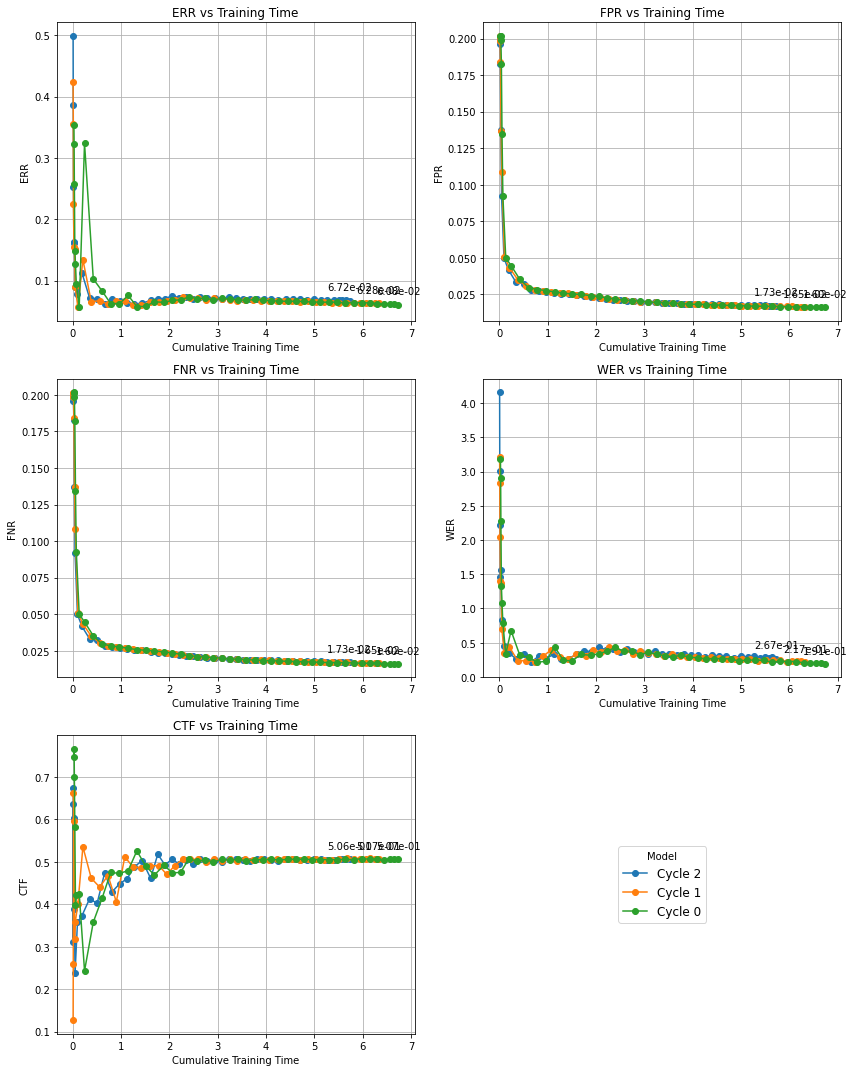

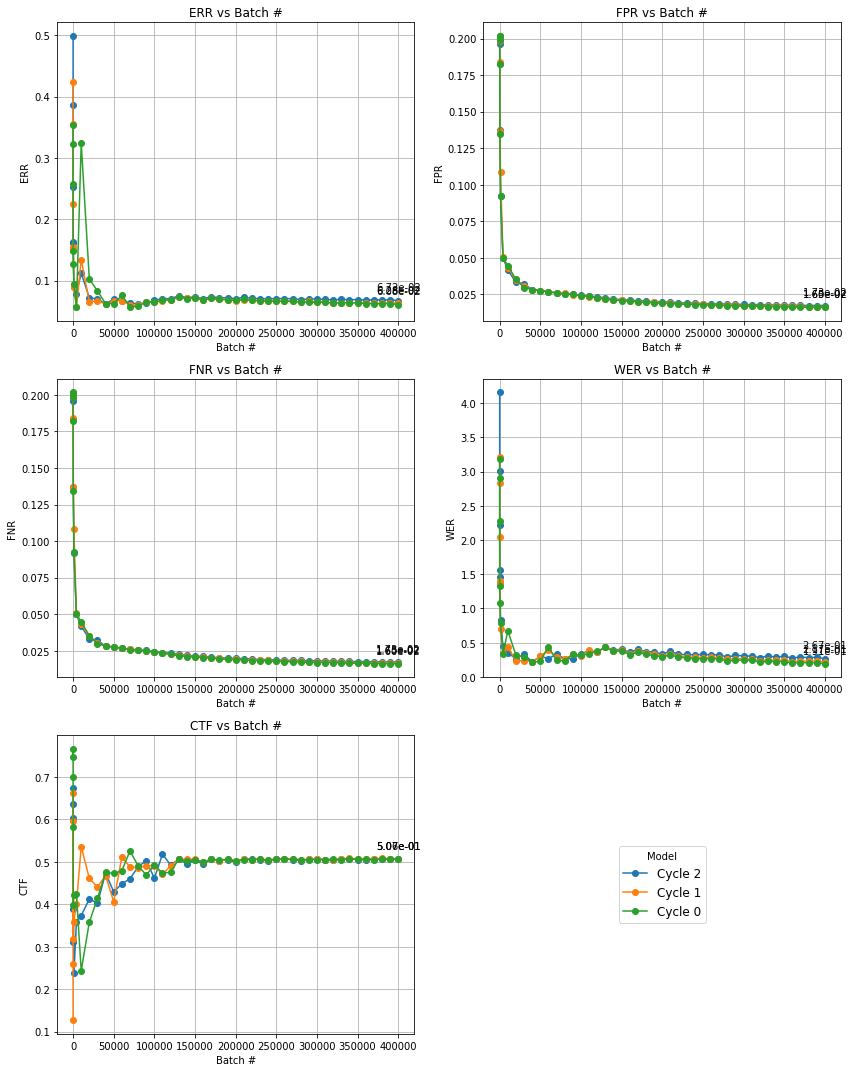

In [21]:
# Load the training history from the JSON file
def load_training_history(json_path="batch_logs.json"):
    """
    Load training history from a JSON file.
    Each entry in the JSON file should have a 'title' and 'batches' key.
    Returns a dictionary where keys are titles and values are lists of batch metrics.
    """
    if not os.path.exists(json_path):
        print(f"JSON file {json_path} does not exist.")
        return {}

    with open(json_path, 'r') as f:
        try:
            logs = json.load(f)
        except json.JSONDecodeError:
            print(f"Error decoding JSON from {json_path}.")
            return {}

    training_history = {}
    for log in logs:
        title = log.get('title')
        batches = log.get('batches', [])
        if title and isinstance(batches, list):
            training_history[title] = batches

    return training_history

training_history = load_training_history("batch_logs_cycles.json")


# Plot training_history as subplots for each metric in a 3x2 grid, legend in bottom right
def plot_training_history_subplots(training_history, timeconversion='hour', selected_keys=None):
    """
    For each metric, create a subplot showing the metric vs cumulative training time for all models.
    Optionally, only plot for selected_keys (a list or a single key).
    Legend is placed in the last subplot (bottom right).
    """
    import matplotlib.pyplot as plt

    metrics_to_plot = ['ERR', 'FPR', 'FNR', 'WER', 'CTF']
    num_metrics = len(metrics_to_plot)
    nrows, ncols = 3, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Handle selected_keys argument
    if selected_keys is not None:
        if isinstance(selected_keys, str):
            selected_keys = [selected_keys]
        keys_to_plot = [k for k in training_history if k in selected_keys]
    else:
        keys_to_plot = list(training_history.keys())

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        for super_key in keys_to_plot:
            history = training_history[super_key]
            training_times = [entry['Training Time'] for entry in history]
            # Compute cumulative training times
            if timeconversion == 'sec':
                cumulative_times = np.cumsum(training_times)
            elif timeconversion == 'min':
                cumulative_times = np.cumsum(training_times) / 60
            elif timeconversion == 'hour':
                cumulative_times = np.cumsum(training_times) / 3600
            else:
                raise ValueError("Invalid time conversion. Use 'sec', 'min', or 'hour'.")
            values = [entry[metric] for entry in history]
            ax.plot(cumulative_times, values, marker='o', linestyle='-', label=super_key)
            # Annotate the last point
            if len(cumulative_times) > 0:
                x_last = cumulative_times[-1]
                y_last = values[-1]
                ax.annotate(f"{y_last:.2e}", (x_last, y_last),
                            textcoords="offset points", xytext=(0, 10),
                            ha='center', fontsize=10, color='black')
        ax.set_xlabel('Cumulative Training Time')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs Training Time')
        ax.grid(True)

    # Remove the last subplot's axes (bottom right) and put the legend there
    legend_ax = axes[-1]
    legend_ax.axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc='center', fontsize=12, title='Model')

    plt.tight_layout()
    plt.show()

def plot_training_history_batch_subplots(training_history, selected_keys=None):
    """
    For each metric, create a subplot showing the metric vs batch # for all models.
    Optionally, only plot for selected_keys (a list or a single key).
    Legend is placed in the last subplot (bottom right).
    """
    import matplotlib.pyplot as plt

    metrics_to_plot = ['ERR', 'FPR', 'FNR', 'WER', 'CTF']
    num_metrics = len(metrics_to_plot)
    nrows, ncols = 3, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Handle selected_keys argument
    if selected_keys is not None:
        if isinstance(selected_keys, str):
            selected_keys = [selected_keys]
        keys_to_plot = [k for k in training_history if k in selected_keys]
    else:
        keys_to_plot = list(training_history.keys())

    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        for super_key in keys_to_plot:
            history = training_history[super_key]
            batch_nums = [entry['Batch'] for entry in history]
            values = [entry[metric] for entry in history]
            ax.plot(batch_nums, values, marker='o', linestyle='-', label=super_key)
            # Annotate the last point
            if len(batch_nums) > 0:
                x_last = batch_nums[-1]
                y_last = values[-1]
                ax.annotate(f"{y_last:.2e}", (x_last, y_last),
                            textcoords="offset points", xytext=(0, 10),
                            ha='center', fontsize=10, color='black')
        ax.set_xlabel('Batch #')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs Batch #')
        ax.grid(True)

    # Remove the last subplot's axes (bottom right) and put the legend there
    legend_ax = axes[-1]
    legend_ax.axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, loc='center', fontsize=12, title='Model')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history_subplots(training_history, 'hour',selected_keys=None)
plot_training_history_batch_subplots(training_history,selected_keys=None)


In [15]:
# Graphing metrics 
# Histogram of FPR, FNR, ERR, WER, CTF
def plot_metrics(metrics):
    labels = list(metrics.keys())
    fpr = [metrics[label]['fpr'] for label in labels]
    fnr = [metrics[label]['fnr'] for label in labels]
    err = [metrics[label]['err'] for label in labels]
    wer = [metrics[label]['wer'] for label in labels]
    ctf = [metrics[label]['ctf'] for label in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars_fpr = ax.bar(x - 2*width, fpr, width, label='FPR')
    bars_fnr = ax.bar(x - width, fnr, width, label='FNR')
    bars_err = ax.bar(x, err, width, label='ERR')
    bars_wer = ax.bar(x + width, wer, width, label='WER')
    bars_ctf = ax.bar(x + 2*width, ctf, width, label='CTF')

    # Annotate bars
    for bars, values in zip([bars_fpr, bars_fnr, bars_err, bars_wer, bars_ctf], [fpr, fnr, err, wer, ctf]):
        for bar, value in zip(bars, values):
            ax.annotate(f'{value:.2g}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Scores')
    ax.set_title('Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [16]:
# Graph the four metrics
#plot_metrics(metrics)

## Results of Evaluation   
### Five Non-Genetic Dimensions (NGD)

- Start Score, Mid Score, End Score, log length / 10, gc ratio


### Six NGD

- Start Score, Mid Score, End Score, log length / 10, gc ratio, entropy

In [ ]:
# Five NGD first, evaluated on ncbi_100_fixed.tsv
cycles_trained_5dims_400k_ncbi_100 = """ERR= 0.054859   WER= 0.111540   FPR= 0.013485   FNR= 0.013476   CTF= 0.534317"""
cycles_trained_5dims_400k_d075_ncbi_100= """ERR= 0.056422   WER= 0.126101   FPR= 0.014081   FNR= 0.014071   CTF= 0.525415"""


# Six NGD, evaluated on ncbi_100_6f.tsv

In [ ]:


#Read omega_training.tsv:
# Use os.path.expanduser to handle '~' in the path
dir = "/home/bimstepf/JGI_2025/"
training_vector_path = os.path.join(dir, "ncbi_10_6f_HC.tsv")
training_df = pd.read_csv(training_vector_path, sep="\t")
# remove NaN columns
training_df = training_df.dropna(axis=1, how='all')

# Get dimensions and start labeling columns
num_rows, num_cols = training_df.shape
# Rename columns to column #
# Rename columns 6 through n-1 to position_1, position_2, ..., position_{n-6}
for i in range(5, num_cols - 1):
    training_df.rename(columns={training_df.columns[i]: f'position_{i - 4}'}, inplace=True)
# Rename specific columns to meaningful names
training_df.rename(columns={training_df.columns[0]: 'log_length'}, inplace=True)
training_df.rename(columns={training_df.columns[1]: 'start_score'}, inplace=True)
training_df.rename(columns={training_df.columns[2]: 'mid_score'}, inplace=True)
training_df.rename(columns={training_df.columns[3]: 'end_score'}, inplace=True)
training_df.rename(columns={training_df.columns[4]: 'gc_ratio'}, inplace=True)
training_df.rename(columns={training_df.columns[5]: 'entropy'}, inplace=True)
training_df.rename(columns={training_df.columns[-1]: 'target'}, inplace=True)

# Get the length of the final column
total_rows = len(training_df.iloc[:, -1])
# Get a summation of the the final column
total_matches = training_df.iloc[:, -1].sum()
# Get the percentage of matches and summation of non-matches
percentage_matches = (total_matches / total_rows) * 100
total_zeros = total_rows - total_matches

# print statistics
print(f"Total rows: {total_rows}")
print(f"Total matches: {total_matches}")
print(f"Total non-matches: {total_zeros}")
print(f"Percentage of matches: {percentage_matches:.2f}%")


FileNotFoundError: [Errno 2] No such file or directory: '/home/bimstepf/JGI_2025/ncbi_10_6f_HC.tsv'

In [5]:
def summary_statistics(df):
    print("Summary Statistics:")
    display(df.describe())
    print("\n Maximum and Minimum Values:")
    print("Maximum Values:")
    display(df.max())
    print("Minimum Values:")
    display(df.min())

In [ ]:
summary_statistics(training_df)

In [ ]:


def plot_training_data(df):
    # Plot the density of the 1st-5th columns
    cols = df.columns[:5]
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        ax = axes[i]
        sns.kdeplot(df[col], ax=ax, fill=True)
        mean = df[col].mean()
        std = df[col].std()
        min_val = df[col].min()
        max_val = df[col].max()
        ax.axvline(mean, color='r', linestyle='--', label='Mean')
        ax.axvline(mean + std, color='g', linestyle=':', label='Mean ± Std')
        ax.axvline(mean - std, color='g', linestyle=':')
        ax.axvline(min_val, color='b', linestyle='-.', label='Min')
        ax.axvline(max_val, color='m', linestyle='-.', label='Max')
        ax.set_title(f"{col}\nmean={mean:.2g}, std={std:.2g}, min={min_val:.2g}, max={max_val:.2g}")
        # Remove legend from individual plots
    # Hide any unused subplots except the last one, which will be used for the legend
    for j in range(len(cols), len(axes) - 1):
        fig.delaxes(axes[j])
    # Add legend to the last subplot (bottom right)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[-1].axis('off')
    axes[-1].legend(handles, labels, loc='center', fontsize=10)
    # Try to use the DataFrame's name attribute if set, otherwise infer from the calling frame
    title_name = getattr(df, 'name', None)
    if title_name is None:
        frame = inspect.currentframe().f_back
        title_name = next((var for var, val in frame.f_locals.items() if val is df), "Data")
    plt.suptitle(f'Density Plots for {title_name}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_training_data(training_df)

In [ ]:
# Separate training data into two sets based on the last column
def separate_training_data(df):
    matches = df[df.iloc[:, -1] == 1]
    non_matches = df[df.iloc[:, -1] == 0]
    return matches, non_matches
matches, non_matches = separate_training_data(training_df)

plot_training_data(matches)
summary_statistics(matches)
plot_training_data(non_matches)
summary_statistics(non_matches)

In [ ]:
# Now a function similar to the plot_training_data function but it overlaps the two sets -- one is amber (matches) and the other is cyan (non_matches)
def plot_overlapping_training_data(matches, non_matches, statistics=False):
    cols = matches.columns[:5]
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        ax = axes[i]
        # Plot KDEs
        sns.kdeplot(matches[col], ax=ax, fill=True, color='turquoise', label='Matches')
        sns.kdeplot(non_matches[col], ax=ax, fill=True, color='orange', label='Non-Matches')
        # Plot statistics if requested
        if statistics:
            # Matches stats (turquoise)
            mean_m = matches[col].mean()
            std_m = matches[col].std()
            min_m = matches[col].min()
            max_m = matches[col].max()
            ax.axvline(mean_m, color='turquoise', linestyle='--', label='Matches Mean')
            ax.axvline(mean_m + std_m, color='turquoise', linestyle=':', label='Matches Mean ± Std')
            ax.axvline(mean_m - std_m, color='turquoise', linestyle=':')
            ax.axvline(min_m, color='turquoise', linestyle='-.', label='Matches Min')
            ax.axvline(max_m, color='turquoise', linestyle='-.', label='Matches Max')
            # Non-matches stats (orange)
            mean_n = non_matches[col].mean()
            std_n = non_matches[col].std()
            min_n = non_matches[col].min()
            max_n = non_matches[col].max()
            ax.axvline(mean_n, color='orange', linestyle='--', label='Non-Matches Mean')
            ax.axvline(mean_n + std_n, color='orange', linestyle=':', label='Non-Matches Mean ± Std')
            ax.axvline(mean_n - std_n, color='orange', linestyle=':')
            ax.axvline(min_n, color='orange', linestyle='-.', label='Non-Matches Min')
            ax.axvline(max_n, color='orange', linestyle='-.', label='Non-Matches Max')
        ax.set_title(f"Overlapping Density Plot for {col}")
        # Remove legend from individual plots
    # Hide unused subplots except the last one, which will be used for the legend
    for j in range(len(cols), len(axes) - 1):
        fig.delaxes(axes[j])
    # Add legend to the last subplot (bottom right)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[-1].axis('off')
    axes[-1].legend(handles, labels, loc='center', fontsize=10)
    plt.suptitle('Overlapping Density Plots for Matches and Non-Matches')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_overlapping_training_data(matches, non_matches, statistics=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr

# 1. Feature Importance with Random Forest
def plot_feature_importance(df, label_col=-1, n_estimators=100, random_state=42):
    """
    Trains a Random Forest classifier and plots the top 10 most important features.
    Args:
        df: pandas DataFrame containing features and label.
        label_col: Index or name of the label column.
        n_estimators: Number of trees in the forest.
        random_state: Seed for reproducibility.
    """
    # Prepare features and label
    X = df.iloc[:, :label_col] if isinstance(label_col, int) else df.drop(columns=[label_col])
    y = df.iloc[:, label_col] if isinstance(label_col, int) else df[label_col]
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)
    importances = rf.feature_importances_
    # Get indices of top 10 features
    top_idx = np.argsort(importances)[-10:][::-1]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[top_idx], y=X.columns[top_idx])
    plt.title('Top 10 Random Forest Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    return importances

In [ ]:
# 2. Permutation Importance for Robust Feature Ranking
def plot_permutation_importance(df, label_col=-1, n_estimators=100, random_state=42):
    """
    Computes and plots permutation feature importance using a trained Random Forest.
    Only the top 10 most important features are shown.
    Args:
        df: pandas DataFrame containing features and label.
        label_col: Index or name of the label column.
        n_estimators: Number of trees in the forest.
        random_state: Seed for reproducibility.
    """
    X = df.iloc[:, :label_col] if isinstance(label_col, int) else df.drop(columns=[label_col])
    y = df.iloc[:, label_col] if isinstance(label_col, int) else df[label_col]
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)
    result = permutation_importance(rf, X, y, n_repeats=10, random_state=random_state)
    importances_mean = result.importances_mean
    # Get indices of top 10 features
    top_idx = np.argsort(importances_mean)[-10:][::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(X.columns[top_idx][::-1], importances_mean[top_idx][::-1])
    plt.xlabel("Permutation Importance")
    plt.title("Top 10 Permutation Feature Importances")
    plt.tight_layout()
    plt.show()
    return result


In [ ]:
# 3. Correlation Matrix and Feature-Label Correlation

def plot_correlation_matrix(df):
    """
    Plots a heatmap of the correlation matrix for all numeric columns in the DataFrame.
    Args:
        df: pandas DataFrame.
    """
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()
    return corr

def print_feature_label_correlation(df, label_col=-1):
    """
    Prints the Pearson correlation of each feature with the label column.
    Args:
        df: pandas DataFrame.
        label_col: Index or name of the label column.
    """
    corr = df.corr()
    label_corr = corr.iloc[:-1, label_col] if isinstance(label_col, int) else corr.loc[:, label_col][:-1]
    print("Correlation of each feature with the label:")
    print(label_corr)
    return label_corr

In [ ]:
# 4. Optimize Context Window Size (requires raw sequence data)

def gc_content(seq):
    """
    Calculates the GC content of a DNA sequence.
    Args:
        seq: String or list of bases (A, T, G, C).
    Returns:
        GC content as a float between 0 and 1.
    """
    seq = ''.join(seq).upper() if not isinstance(seq, str) else seq.upper()
    gc = seq.count('G') + seq.count('C')
    return gc / len(seq) if len(seq) > 0 else 0

def plot_gc_distribution_by_window(seqs, window_sizes):
    """
    Plots GC content distributions for different window sizes.
    Args:
        seqs: List of sequences (strings or lists of bases).
        window_sizes: List of integers (window sizes to test).
    """
    for w in window_sizes:
        gc_vals = []
        for seq in seqs:
            for i in range(0, len(seq) - w + 1):
                window = seq[i:i+w]
                gc_vals.append(gc_content(window))
        plt.hist(gc_vals, bins=30, alpha=0.5, label=f'Window {w}')
    plt.xlabel('GC Content')
    plt.ylabel('Frequency')
    plt.title('GC Content Distribution by Window Size')
    plt.legend()
    plt.show()

In [ ]:
# Plot correlation matrix without annotation numbers and with a smaller colorbar
def plot_correlation_matrix_simple(df,title=''):
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=False, cmap='coolwarm', cbar_kws={'shrink': 0.5})
    plt.title('Correlation Matrix: ' + title)
    plt.show()

#plot_correlation_matrix_simple(training_df, title='Training Data')
#print_feature_label_correlation(training_df, label_col='target')

In [ ]:
def correlation_list(df, label_col=-1):
    """
    Returns a list of tuples containing feature names and their correlation with the label column.
    Args:
        df: pandas DataFrame.
        label_col: Index or name of the label column.
    Returns:
        List of tuples (feature_name, correlation_value).
    """
    corr = df.corr()
    if isinstance(label_col, int):
        label_corr = corr.iloc[:-1, label_col]
    else:
        label_corr = corr.loc[:, label_col][:-1]
    return list(label_corr.items())

#total_corr_list = correlation_list(training_df, label_col='target')

def print_correlation_list(corr_list, title='', printed=25):
    """
    Prints a formatted list of feature correlations in descending order.
    Args:
        corr_list: List of tuples (feature_name, correlation_value).
        title: Title for the printed list.
        printed: Number of features to print, defaults to 10.
    """
    print(f"\n{title} Correlation List:")
    print("Descending order:")
    for feature, corr_value in sorted(corr_list, key=lambda x: x[1], reverse=True)[:printed]:
        print(f"{feature}: {corr_value:.4f}")
    print("Ascending order:")
    for feature, corr_value in sorted(corr_list, key=lambda x: x[1], reverse=False)[:printed]:
        print(f"{feature}: {corr_value:.4f}")
        
#print_correlation_list(total_corr_list, title='Total')

In [ ]:
#plot_feature_importance(training_df, label_col='target')

In [ ]:

def compute_shannon_entropy(df):
    """
    Computes per-position Shannon entropy for one-hot encoded sequence columns.
    Args:
        df: pandas DataFrame with one-hot encoded sequence columns (e.g., col_6 ... col_N).
    Returns:
        List of entropy scores for each position.
    """
    seq_cols = [col for col in df.columns if col.startswith('position_') and col != 'target']
    if not seq_cols:
        print("No one-hot encoded sequence columns found.")
        return []
    n_positions = len(seq_cols)
    scores = []
    for i in range(n_positions):
        col = seq_cols[i]
        counts = df[col].value_counts(normalize=True)
        entropy = -np.sum([p * np.log2(p) for p in counts if p > 0])
        scores.append(entropy)
    return scores

def shannon_entropy_plot(scores, title='Shannon Entropy Plot', demarcate=True, region=None):
    """
    Plots per-position conservation scores (Shannon entropy).
    Args:
        scores: List of entropy scores for each position.
        title: Title for the plot.
        demarcate: If True, draw vertical lines at 1/3 and 2/3 of the sequence.
        region: 'start', 'middle', 'stop', or None. If set, only plot that region.
    """
    if not scores:
        print("No entropy scores to plot.")
        return

    n = len(scores)
    # Determine region indices
    if region == 'start':
        idx_start, idx_end = 0, n // 3
    elif region == 'middle':
        idx_start, idx_end = n // 3, 2 * n // 3
    elif region == 'stop':
        idx_start, idx_end = 2 * n // 3, n
    else:
        idx_start, idx_end = 0, n

    region_scores = scores[idx_start:idx_end]
    plt.figure(figsize=(12, 5))
    plt.plot(
        range(idx_start + 1, idx_end + 1),
        region_scores,
        marker='o',
        color='slategray',
        alpha=0.7,
        linewidth=2,
        markerfacecolor='gold',
        markersize=6
    )
    if demarcate and region is None:
        plt.axvline(x=n // 3 + 1, color='black', linestyle=':', linewidth=2, label='Start/Middle boundary')
        plt.axvline(x=2 * n // 3 + 1, color='black', linestyle=':', linewidth=2, label='Middle/Stop boundary')
    plt.title(title if region is None else f"{title} ({region.capitalize()})")
    plt.xlabel('Position in One-Hot Sequence')
    plt.ylabel('Shannon Entropy')
    if demarcate and region is None:
        plt.legend()
    plt.tight_layout()
    plt.show()


total_shannon_scores = compute_shannon_entropy(training_df)
matches_shannon_scores = compute_shannon_entropy(matches)
non_matches_shannon_scores = compute_shannon_entropy(non_matches)
t = time.time()
shannon_entropy_plot(total_shannon_scores, title='Total Shannon Entropy Plot', demarcate=True)
elapsed = time.time() - t
print(f"Time taken for total shannon entropy plot: {elapsed:.2f} seconds")
print(f"Mean of total shannon scores: {np.mean(total_shannon_scores):.4f}")
print(f"Variance of total shannon scores: {np.var(total_shannon_scores):.4f}")


t = time.time()
shannon_entropy_plot(matches_shannon_scores, title='Matches Only Shannon Entropy Plot', demarcate=True)
elapsed = time.time() - t
print(f"Time taken for matches shannon entropy plot: {elapsed:.2f} seconds")
print(f"Mean of matches shannon scores: {np.mean(matches_shannon_scores):.4f}")
print(f"Variance of matches shannon scores: {np.var(matches_shannon_scores):.4f}")




t = time.time()
shannon_entropy_plot(non_matches_shannon_scores, title='Non-Matches Only Shannon Entropy Plot', demarcate=True)
elapsed = time.time() - t
print(f"Time taken for non-matches shannon entropy plot: {elapsed:.2f} seconds")
print(f"Mean of non-matches shannon scores: {np.mean(non_matches_shannon_scores):.4f}")
print(f"Variance of non-matches shannon scores: {np.var(non_matches_shannon_scores):.4f}")


# Overlap the matches and non-matches shannon entropy plots
def plot_overlapping_shannon_entropy(matches_scores, non_matches_scores):
    """
    Plots overlapping Shannon entropy scores for matches and non-matches.
    Args:
        matches_scores: List of Shannon entropy scores for matches.
        non_matches_scores: List of Shannon entropy scores for non-matches.
    """
    if not matches_scores or not non_matches_scores:
        print("No scores to plot.")
        return
    plt.figure(figsize=(12, 5))
    plt.plot(
        range(1, len(matches_scores) + 1),
        matches_scores,
        marker='o',
        color='turquoise',
        alpha=0.7,
        linewidth=2,
        label='Matches',
        markersize=6
    )
    plt.plot(
        range(1, len(non_matches_scores) + 1),
        non_matches_scores,
        marker='o',
        color='orange',
        alpha=0.7,
        linewidth=2,
        label='Non-Matches',
        markersize=6
    )
    n = len(matches_scores)
    plt.axvline(x=n // 3 + 1, color='black', linestyle=':', linewidth=2)
    plt.axvline(x=2 * n // 3 + 1, color='black', linestyle=':', linewidth=2)
    plt.title('Overlapping Shannon Entropy Plot')
    plt.xlabel('Position in One-Hot Sequence')
    plt.ylabel('Shannon Entropy')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_overlapping_shannon_entropy(matches_shannon_scores, non_matches_shannon_scores)


# Plot the middle region of the matches entropy plot
shannon_entropy_plot(matches_shannon_scores, title='Matches Only Mid Shannon Entropy Plot', demarcate=True, region='middle')


In [ ]:
from scipy.signal import periodogram

def measure_periodicity(scores, plot=True, title='Periodicity Analysis', return_integer_period=True):
    """
    Measures periodicity in a sequence of scores using the periodogram (FFT-based).
    Args:
        scores: List or 1D numpy array of scores (e.g., Shannon entropy per position).
        plot: If True, plot the periodogram.
        title: Title for the plot.
        return_integer_period: If True, returns the strongest period as an integer.
    Returns:
        freqs: Array of frequency bins.
        power: Array of power spectral density values.
        period: Strongest periodicity as an integer (if return_integer_period), else None.
    """
    scores = np.asarray(scores)
    # Remove mean to focus on oscillatory components
    scores_demeaned = scores - np.mean(scores)
    freqs, power = periodogram(scores_demeaned)
    period = None
    if len(power) > 1:
        peak_idx = np.argmax(power[1:]) + 1
        if freqs[peak_idx] > 0:
            period = 1 / freqs[peak_idx]
            if return_integer_period:
                period = int(round(period))
            if plot:
                print(f"Strongest periodicity: period ≈ {period} positions (frequency={freqs[peak_idx]:.4f})")
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(freqs[1:], power[1:], marker='o')  # skip the zero frequency (mean)
        plt.xlabel('Frequency')
        plt.ylabel('Power')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    if return_integer_period:
        return freqs, power, period
    else:
        return freqs, power

# Example usage:
# split scores into thirds for periodicity analysis
total_shannon_scores = np.array(total_shannon_scores)
if len(total_shannon_scores) > 0:
    third_len = len(total_shannon_scores) // 3
    first_third = total_shannon_scores[:third_len]
    second_third = total_shannon_scores[third_len:2*third_len]
    third_third = total_shannon_scores[2*third_len:]

    print("Periodicity for first third:")
    measure_periodicity(first_third)

    print("Periodicity for second third:")
    measure_periodicity(second_third)

    print("Periodicity for third third:")
    measure_periodicity(third_third)

In [ ]:
# print the locations of the most likely start and stop codons (the lowest shannon entropy scores)
def print_start_stop_codons(scores, threshold=0.1):
    """
    Prints the positions of the most likely start and stop codons based on Shannon entropy scores.
    Args:
        scores: List of Shannon entropy scores.
        threshold: Threshold below which a position is considered a likely start/stop codon.
    """
    start_codons = [i + 1 for i, score in enumerate(scores) if score < threshold]
    if start_codons:
        print(f"Likely Start Codon Positions (Entropy < {threshold}): {start_codons}")
    else:
        print("No likely start codons found.")
    
    stop_codons = [i + 1 for i, score in enumerate(scores) if score < threshold]
    if stop_codons:
        print(f"Likely Stop Codon Positions (Entropy < {threshold}): {stop_codons}")
    else:
        print("No likely stop codons found.")
print_start_stop_codons(total_shannon_scores, threshold=0.1)


In [ ]:
# Now, we can load the same vector but with gene sequences instead of the encoding:
training_genes_df = pd.read_csv(os.path.join(dir, "sh_test_seq_vector.tsv"), sep="\t")
# Do the same column renaming as before:
training_genes_df = training_genes_df.dropna(axis=1, how='all')
# Rename columns to column #
for i in range(training_genes_df.shape[1]):
    training_genes_df.rename(columns={training_genes_df.columns[i]: f'col_{i+1}'}, inplace=True)
# Rename specific columns to meaningful names
training_genes_df.rename(columns={training_genes_df.columns[0]: 'log_length'}, inplace=True)
training_genes_df.rename(columns={training_genes_df.columns[1]: 'start_score'}, inplace=True)
training_genes_df.rename(columns={training_genes_df.columns[2]: 'mid_score'}, inplace=True)
training_genes_df.rename(columns={training_genes_df.columns[3]: 'end_score'}, inplace=True)
training_genes_df.rename(columns={training_genes_df.columns[4]: 'gc_ratio'}, inplace=True)
training_genes_df.rename(columns={training_genes_df.columns[-1]: 'target'}, inplace=True)
# Get the length of the final column
total_rows_genes = len(training_genes_df.iloc[:, -1])
# Get a summation of the the final column
total_matches_genes = training_genes_df.iloc[:, -1].sum()
# Get the percentage of matches and summation of non-matches
percentage_matches_genes = (total_matches_genes / total_rows_genes) * 100
total_zeros_genes = total_rows_genes - total_matches_genes
# print statistics
print(f"\nTotal rows (genes): {total_rows_genes}")
print(f"Total matches (genes): {total_matches_genes}")
print(f"Total non-matches (genes): {total_zeros_genes}")
print(f"Percentage of matches (genes): {percentage_matches_genes:.2f}%")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

'''

# 1. Prepare the data (exclude the target column)
features = training_df.drop(columns=['target'])
labels = training_df['target']

# 2. Standardize features (important for PCA)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 3. Fit PCA
n_components = min(10, features.shape[1])  # up to 10 PCs for inspection
pca = PCA(n_components=n_components, random_state=42)
principal_components = pca.fit_transform(features_scaled)

# 4. Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

plt.figure(figsize=(8, 4))
plt.bar(range(1, n_components+1), explained_var, alpha=0.7, label='Individual')
plt.plot(range(1, n_components+1), cumulative_var, marker='o', color='red', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

print("Variance explained by first 2 PCs: {:.2f}%".format(100 * cumulative_var[1]))
print("Variance explained by first 10 PCs: {:.2f}%".format(100 * cumulative_var[-1]))

'''

# Nonlinear Dimensionality Reduction: t-SNE and UMAP

PCA is a linear method and may not capture complex, nonlinear relationships in high-dimensional data. t-SNE and UMAP are powerful nonlinear dimensionality reduction techniques that can reveal hidden clusters and structure.

- **t-SNE** (t-distributed Stochastic Neighbor Embedding): Good for visualizing local clusters, but can be slow for large datasets.
- **UMAP** (Uniform Manifold Approximation and Projection): Preserves both local and global structure, often faster and more scalable than t-SNE.

Below, we apply both methods to your data and visualize the results, coloring points by the target label.

In [ ]:
from sklearn.manifold import TSNE

# t-SNE is sensitive to scale, so use the same scaled features as PCA
# t-SNE can be slow; for very large datasets, consider subsampling


'''

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(features_scaled)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE: Nonlinear Embedding of High-Dimensional Data')
plt.colorbar(scatter, label='Target')
plt.tight_layout()
plt.show()

'''

## Interpreting the t-SNE Plot

- Each point is a sample projected into a nonlinear 2D space.
- Clusters or separation by color (target) suggest meaningful structure.
- t-SNE is best for visualizing local clusters, but distances between clusters may not be meaningful.

## Interpreting the Explained Variance Plot

- **Individual bars** show how much variance each principal component (PC) captures.
- **Cumulative line** shows the total variance captured as you add more PCs.
- If the first 2-3 PCs capture a large portion of the variance, 2D/3D plots will be informative. If not, the data may be highly distributed or nonlinear, and other methods (t-SNE, UMAP) may be more revealing.

In [ ]:
# 5. Visualize the first two principal components, colored by target

'''
plt.figure(figsize=(7, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(scatter, label='Target')
plt.tight_layout()
plt.show()

'''

## Interpreting the PCA Scatter Plot

- Each point is a gene/sample projected into the space of the first two principal components.
- Color indicates the target value (e.g., match/non-match).
- Clusters or separation between classes suggest that the features capture meaningful structure.
- Overlap may indicate that the classes are not linearly separable, or that more components are needed.

### What if PCA does not reveal clear structure?

- Try nonlinear methods like t-SNE or UMAP, which can capture complex relationships.
- Examine feature loadings to see which features contribute most to each PC.
- Use clustering algorithms (e.g., k-means, hierarchical clustering) to find groups.

---

In [ ]:
'''# 6. Examine feature loadings for the first two principal components
loading_df = pd.DataFrame(pca.components_[:2], columns=features.columns, index=['PC1', 'PC2']).T
loading_df['abs_PC1'] = loading_df['PC1'].abs()
loading_df['abs_PC2'] = loading_df['PC2'].abs()

# Top contributing features for PC1 and PC2
top_pc1 = loading_df.sort_values('abs_PC1', ascending=False).head(10)
top_pc2 = loading_df.sort_values('abs_PC2', ascending=False).head(10)

print("Top 10 features contributing to PC1:")
display(top_pc1[['PC1']])
print("\nTop 10 features contributing to PC2:")
display(top_pc2[['PC2']])
'''